In [ ]:
!pip install -q -r requirements.txt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from collections import Counter
from dataset_class import *

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'

In [2]:
train_path = '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_training'
val_path =  '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_validation'
training_file_path = os.path.join(train_path, 'train.csv')
validation_file_path = os.path.join(val_path, 'validation_data.csv')

In [4]:
toxicity_train = pd.read_csv(f'{training_file_path}')
toxicity_train['label'] = np.where(toxicity_train.target > 0.5, 1, 0)

count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

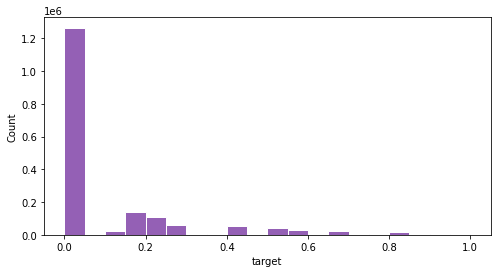

In [6]:
# take a look at distribution
print(toxicity_train.target.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.target, binwidth = .05, color = violet, ax = ax)


In [5]:
## make new dataframe
toxic = toxic_dataset(df = toxicity_train, text = toxicity_train.comment_text, 
                      toxicity = toxicity_train.target, size = 10000, label = toxicity_train.label, seed = 1011)

toxic.make_dataframe(down_sample = True, make_pairs = True)

toxic.df

paired up ...
made new dataframe ...


,more_toxic_text,less_toxic_text,toxicity_more_toxic,toxicity_less_toxic,labels_more_toxic,labels_less_toxic
0,Same lame arguments we heard in 2010 about Mea...,That bumper is an easy touch up with paint kit...,0.000000,0.000000,0,0
1,What a joke! Are these rump supporters even co...,meanwhile childish alt left hating lunatics li...,0.613333,0.481481,1,0
2,I believe 1Oakland. Robert E. Lee was indicte...,Think Maliki very much did not want to be perc...,0.166667,0.000000,0,0
3,You are believing the liberal lies. It is no...,Arroyo would probably be more at home at Breit...,0.318841,0.166667,0,0
4,This shows how the fake news is so stupid. If ...,It's not enough what the UO admin is doing is ...,0.754098,0.300000,1,0
...,...,...,...,...,...,...
9995,"The Model T was cheap, but it was a dangerous ...",OK Dr. Corbiel: WickiU M.D.: pneumonia contrac...,0.500000,0.166667,0,0
9996,I personally have no problem with immigration....,So team Clinton wants to infiltrate the Cathol...,0.600000,0.300000,1,0
9997,Not even 2 months in office and his administra...,"Did you run out of ""Active"" monikers Edwin. Ha...",0.500000,0.100000,0,0
9998,I find your constant preoccupation with sex an...,More silliness from the sawed off wanna be dic...,0.500000,0.360656,0,0


In [ ]:
# take a look at distribution
print(toxicity_train.severe_toxicity.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.severe_toxicity, binwidth = .05, color = violet, ax = ax)


In [ ]:
train_jtc = pd.read_csv(f'{os.path.join(train_path, "train_jtc.csv")}')
train_jtc.nunique()

In [ ]:
# take a look at distribution
print(train_jtc.toxic.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(train_jtc.toxic, binwidth = .05, color = violet, ax = ax)

In [ ]:
toxicity_valid = pd.read_csv(f'{validation_file_path}')
print(toxicity_valid.nunique())
print(toxicity_valid.shape)

In [ ]:
## preprocess validation dataset 
texts = set(toxicity_valid.less_toxic.to_list() + toxicity_valid.more_toxic.to_list())
text2id = {t:id for id,t in enumerate(texts)}
toxicity_valid['less_id'] = toxicity_valid['less_toxic'].map(text2id)
toxicity_valid['more_id'] = toxicity_valid['more_toxic'].map(text2id)
toxicity_valid_grouped = toxicity_valid.groupby(['less_id', 'more_id']).first().reset_index().drop(['less_id', 'more_id'], axis = 1)

In [ ]:
toxicity_valid_grouped